# Part 4: Forecasting with Deep Learning

## Tabular vs. Non-Tabular Models

In the previous notebook, we used a tabular machine learning model for forecasting. Tabular models, such as [decision forests](https://developers.google.com/machine-learning/decision-forests), [feed-forward neural networks](https://en.wikipedia.org/wiki/Feedforward_neural_network), [SVMs](https://en.wikipedia.org/wiki/Support_vector_machine), and [Nearest neighbors](https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm) work well when each column of the dataset represents an independent piece of information.

However, not all datasets are tabular. In non-tabular data, the key patterns or discriminative information lie in the relationships between features, not just their individual values. Consider an [image classification task](https://en.wikipedia.org/wiki/Computer_vision#Recognition) where the objective is to detect cats: treating each pixel as an independent column in a tabular model ignores the spatial relationships that define a cat's shape. The model might learn to recognize cats in one specific location, but struggle to generalize that knowledge to other parts of the image.

Simple neural networks, like feed-forward networks, suffer from the problem described above. However, neural networks have a peculiarity: their architecture is flexible. This flexibility allows us to design architectures to consume special types of non-tabular data such as images, graphs, text... and time series. You might have heard of architecture names such as [convolutional neural networks](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNNs), [recurrent neural networks](https://en.wikipedia.org/wiki/Recurrent_neural_network) (RNNs), [graph neural networks](https://en.wikipedia.org/wiki/Graph_neural_network) (GNN), or [transformers](https://en.wikipedia.org/wiki/Transformer_(deep_learning_architecture)).

## Neural Networks for Time Series

In this tutorial, we'll explore how to use specialized neural networks for time series forecasting.

Some of the noteworthy models in this category include **DeepAR**, **NHits** and **PatchTST** - which use a recurrent, MLP, and transformer-based architecture respectively.

There's a problem with these though - they need to be trained. And training a huge transformer network, like PatchTST, is costly, slow and requires a lot of data. This is why a new class of models started emerging last year: **foundational** time series models.

Think of foundational models as the equivalent of big pretrained LLMs (since they pretty much are) - they are pretrained on enormous amounts of data, and can be applied zero-shot (i.e., without re-training) on unseen time series. Some noteworthy models in this area include Nixtla's TimeGPT, Google's TimesFM, and AWS' Chronos.

Note that this is very much an active area of research - and we are presenting them as an interesting development rather than as a recommended approach for a production system :)

Designing neural network architectures can be complex, so we'll focus on two libraries that provide pre-configured models, making them easier to use:

- **DeepAR**: This model uses an autoregressive recurrent neural network architecture. We will train this model and then generate predictions. See the [paper](https://arxiv.org/abs/1704.04110) for more details.
- **TimesFM**: This is a foundational model using a transformer architecture. See the [paper](https://arxiv.org/abs/2310.10688) for more details.

## Preparation

For optimal performance, run this notebook on a GPU if available. If you're using Google Colab, you can add a GPU in "Edit / Notebook Settings / T4 GPU".


In [1]:
# If SOLVING_EXERCISES=True, runs the user's answers.
# If SOLVING_EXERCISES=False, only runs the provided solutions.
SOLVING_EXERCISES = True


## Dependencies

In [2]:
!pip install matplotlib pandas "numpy<2.0.0" gluonts[torch] timesfm -qq -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.2/440.2 kB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.4/101.4 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.8/686.8 kB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 60.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

<font color="red">WARNING:</font> Restart the notebook / colab kernel after the `pip install` commands above (e.g., Menu > Runtime / Restart settion). If you don't, you might get the `module 'numpy.linalg._umath_linalg' has no attribute '_ilp64'` error.

In [1]:
from typing import Any
from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import timesfm

from gluonts.torch import DeepAREstimator
from gluonts.dataset.repository.datasets import get_dataset as gluonts_get_dataset
from gluonts.dataset.util import to_pandas as gluonts_to_pandas
from gluonts.dataset.split import DateSplitter

/usr/local/lib/python3.10/dist-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


## ETT Dataset

Electricity is notoriously difficult to store, making accurate predictions of both consumption and the behavior of electrical installations a critical concern. Inaccurate forecasts can lead to imbalances in the power grid, inefficiencies, and even outages. In this notebook, we will use the ETT (Electricity Transformer Temperature) dataset. This real-world dataset contains data of two electricity transformers located in China over two years and sampled every hour. The dataset contains the oil temperature, which is what we will be forecasting, as well as various aspects of the transformers.

See more details at: https://github.com/zhouhaoyi/ETDataset

We first load the dataset using the Gluon library.

In [2]:
gluon_dataset = gluonts_get_dataset("ett_small_1h", regenerate=False).test

While the gluon data structure is well suited for this dataset, we convert it into a simpler format that can be used with other libraries.

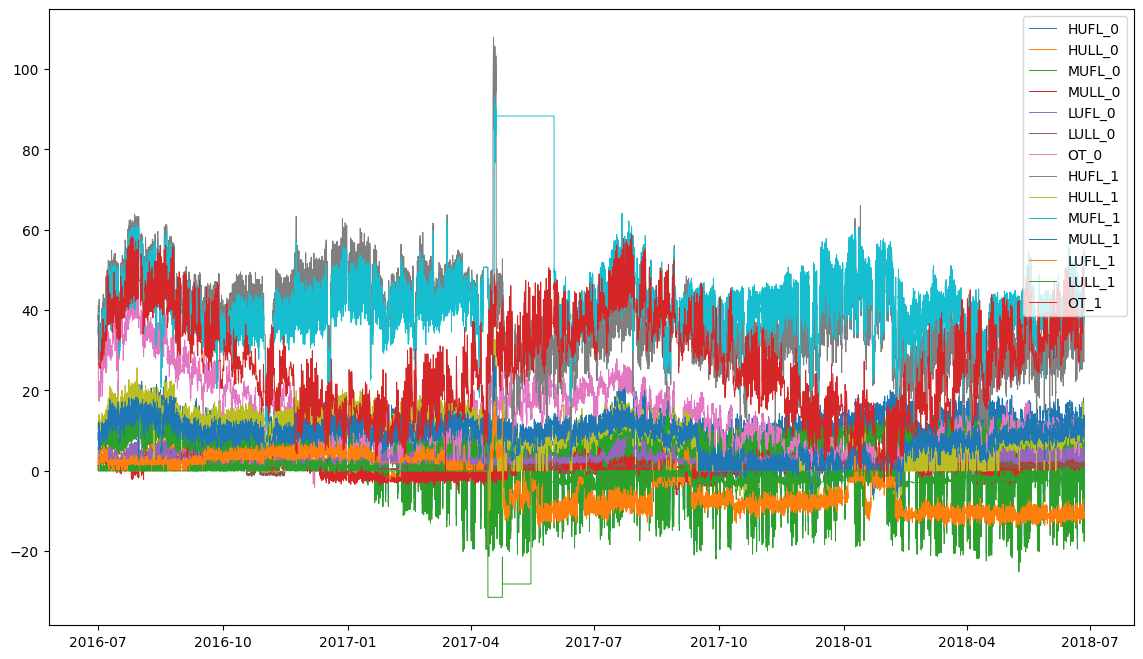

In [3]:
@dataclass
class TimeSeries:
  """A multi-variate time series.

  Attributes:
    timestamps: The "n" timestamps of the time series.
    features: A dictionary of feature values. Each feature value contains "n"
      elements corresponding to the "n" timestamps.
  """
  timestamps: list[datetime]
  features: dict[str, np.ndarray]

def gluon_ds_to_timeseries(gluon_ds) -> TimeSeries:
  """Converts a Gluon dataset into our timeseries format."""
  timestamps = None
  features = {}
  for x in gluon_ds:
    if timestamps is None:
      timestamps = [ x["start"].start_time + timedelta(hours=i) for i in range(len(x["target"])) ]
    features[x["item_id"]] = x["target"]
  return TimeSeries(timestamps=timestamps,features=features)

# Convert the dataset to our format
dataset = gluon_ds_to_timeseries(gluon_dataset)

# Plot the dataset
fig, ax = plt.subplots(figsize=(14, 8))
for name, feature in dataset.features.items():
  ax.plot(dataset.timestamps, feature, label=name, linewidth=0.7)
ax.legend();

In the plot above, you can see the various time series in the dataset. We are mostly interested in the oil temperature of the two transformers, marked as "OT_0" and "OT_1".

We extract extract the end-date of the dataset.

In [4]:
end_of_data = dataset.timestamps[-1]
end_of_data

Timestamp('2018-06-26 19:00:00')

We make predictions on the last week of data, so that we can compare our predictions with the real data. However, we need to "mask" this last week of data from the models.

In [5]:
end_of_train = end_of_data - timedelta(days=7)
end_of_train

Timestamp('2018-06-19 19:00:00')

In the next plot the red vertical line shows the separation between the data available and the data not available to the model. To make the plot more readable, we plot 3 weeks of data.

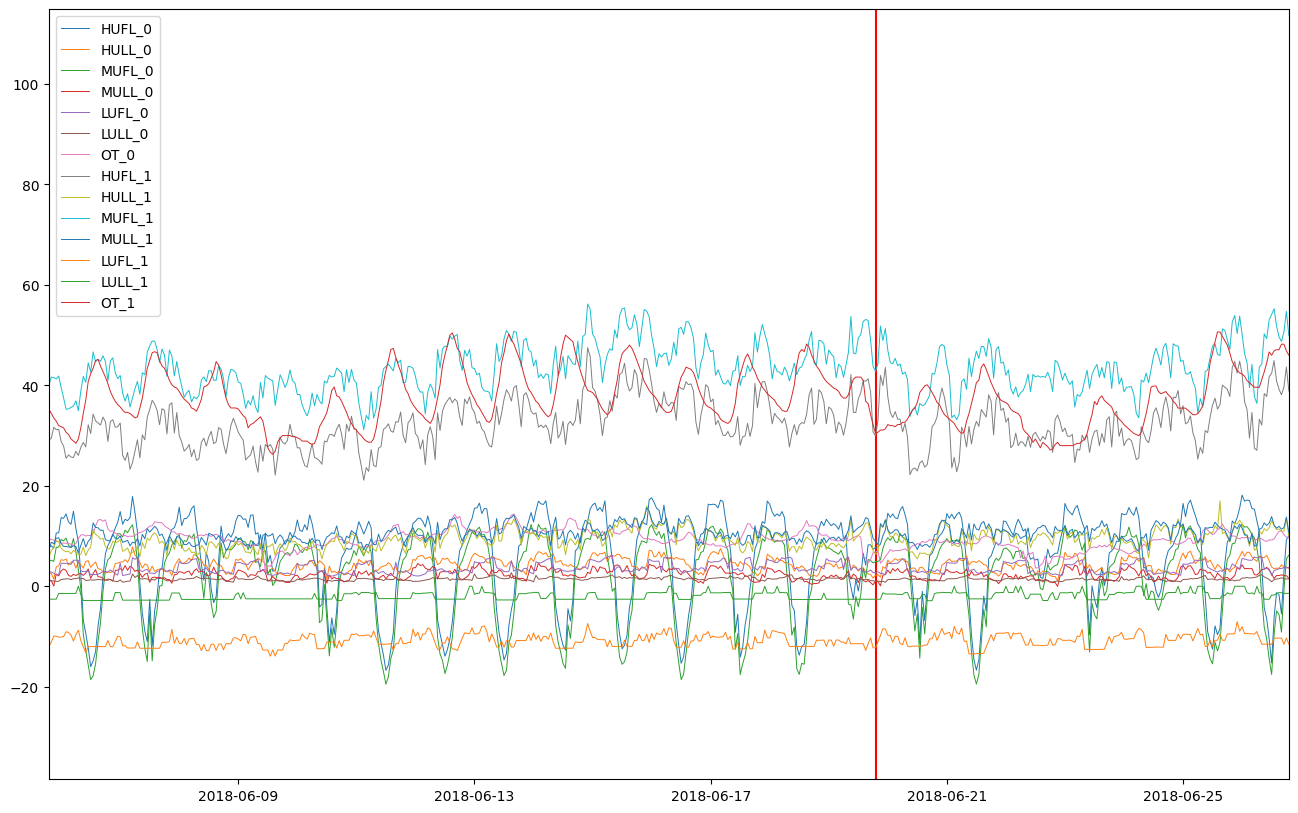

In [6]:
fig, ax = plt.subplots(figsize=(16, 10))
# Separation between available and non available data.
plt.axvline(end_of_train, color="r")
# Plot a 3 weeks window of data.
ax.set_xlim(
    left=end_of_train - timedelta(days=14),
    right=end_of_data,
)

for name, feature in dataset.features.items():
  ax.plot(dataset.timestamps, feature, label=name, linewidth=0.7)
ax.legend();

## DeepAR

We train a DeepAR model on the masked data.

### Exercise

Create the following 2 objects, following each's documentation:
- A [DateSplitter](https://ts.gluon.ai/stable/api/gluonts/gluonts.dataset.split.html?highlight=datesplitter#gluonts.dataset.split.DateSplitter), which splits splits our dataset into train and test splits on `end_of_train`.
- A [DeepAREstimator](https://ts.gluon.ai/stable/api/gluonts/gluonts.mx.model.deepar.html#gluonts.mx.model.deepar.DeepAREstimator), which predicts 7 days ahead, on an hourly frequency. Pass `trainer_kwargs={"max_epochs": 5}` to it to limit how long its training will take.

In [ ]:
if SOLVING_EXERCISES:
    splitter = ...  # YOUR CODE HERE

    gluon_train_ds, gluon_test_ds = splitter.split(gluon_dataset)

    learner = ...  # YOUR CODE HERE

    model = learner.train(gluon_train_ds)

In [7]:
#@title Solution

splitter = DateSplitter(date=pd.Period(end_of_train, "h"))

gluon_train_ds, gluon_test_ds = splitter.split(gluon_dataset)

learner = DeepAREstimator(
    prediction_length=24 * 7,
    freq="h",
    trainer_kwargs={
        # Hyper-parameters of the learner / estimator.
        # Check documentation for other parameters.
        "max_epochs": 5,
        },
    )

model = learner.train(gluon_train_ds)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name  | Type        | Params | In sizes                                                       | Out sizes    
----------------------------------------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'train_loss' reached 2.62771 (best 2.62771), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 2.62771 (best 2.62771), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO: Epoch 1, global step 100: 'train_loss' reached 1.98620 (best 1.98620), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached 1.98620 (best 1.98620), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO: Epoch 2, global step 150: 'train_loss' reached 1.76988 (best 1.76988), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 150: '

We use the trained model to generate predictions, and convert the Gluon prediction object into our Timeseries data structure.

In [8]:
def gluon_predictions_to_timeseries(model, gluon_test_ds):
  timestamps = None
  features = {}
  X = gluon_test_ds.generate_instances(prediction_length=24 * 7)
  for x in model.predict(X.input):
    if timestamps is None:
      timestamps = x.index.to_timestamp()
    features[x.item_id] = x.mean
  return TimeSeries(timestamps=timestamps,features=features)

predictions = gluon_predictions_to_timeseries(model, gluon_test_ds)

Finally, we can plot the model prediction alongside the real data.

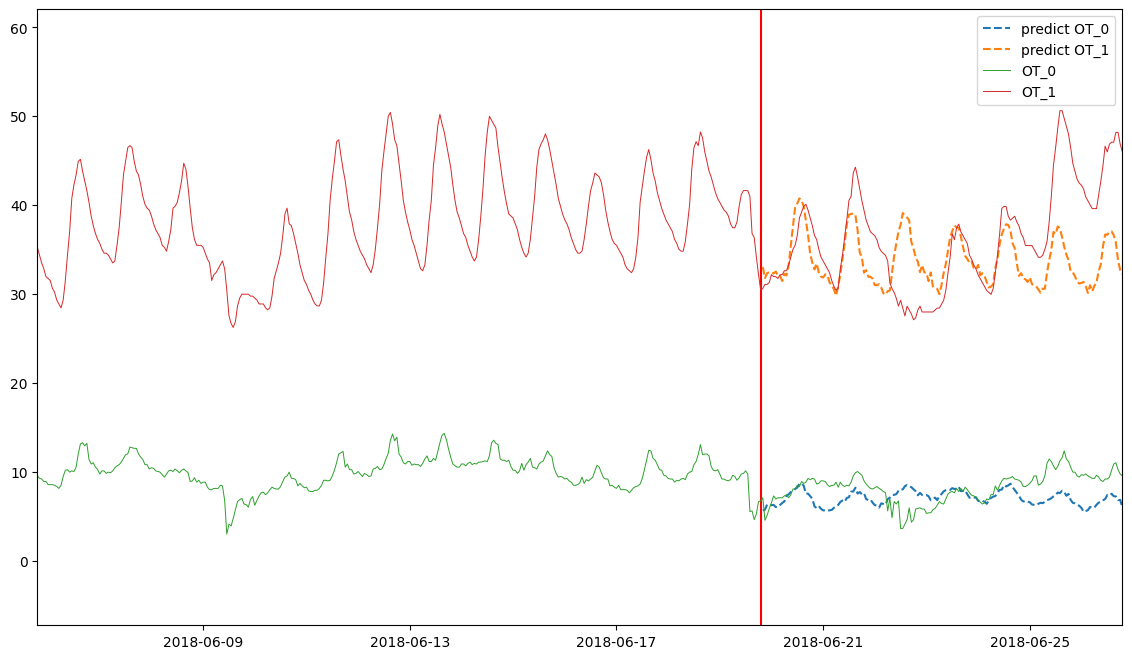

In [9]:
def plot_predictions(predictions, dataset, end_of_data, end_of_train):
    fig, ax = plt.subplots(figsize=(14, 8))

    # Separation between available and non available data.
    plt.axvline(end_of_train, color="r")

    # Plot a 3 weeks window of data.
    ax.set_xlim(
        left=end_of_train - timedelta(days=14),
        right=end_of_data,
    )

    # Select the features to display.
    name_of_interest = ["OT_0", "OT_1"]

    def display(name):
      for n in name_of_interest:
        if n in name:
          return True
      return False

    # Predictions
    for name, feature in predictions.features.items():
        if not display(name):
            continue
        ax.plot(predictions.timestamps, feature, label=f"predict {name}", linestyle="dashed")

    # Real values
    for name, feature in dataset.features.items():
        if not display(name):
            continue
        ax.plot(dataset.timestamps, feature, label=name, linewidth=0.7)

    ax.legend()

plot_predictions(predictions, dataset, end_of_data, end_of_train)

We can see that the model was able to learn the overall shape of the oil temperature of each transformer (e.g. OT_1 has a strong daily pattern while OT_0 is flatter), but both models are over-estimating the temperature.

The model was trained with "out-of-the-box" parameter settings, except for reducing the number of epoch to speed-up training. In other words, we used the default hyper-parameter values.

Out-of-the-box results can be useful baselines, but for practical applications, it is crucial to use tune the optimizer the hyper-parameters (e.g., automated hyper-parameter tuning) with train-valid-test protocol (see previous notebook).


#### Question (If you have time)

Create a 4*7 = 28 days validation dataset and optimize the hyper-parameters of the estimator.


## TimesFM

TimesFM is a foundational model - an ML model trained on a large amount of diverse datasets and which can be used out-of-the-box without extra training.
While foundational models can be fine-tuned for improved performance on specific tasks, this operation is computationally expensive. So, for this tutorial, we'll use TimesFM out-of-the-box.

Often, foundational models have multiple versions of increased complexity and prediction quality. However, currently, only one version of TimesFM was released so we will use this one.

### Exercise

Create a [timesfm.TimesFm](https://github.com/google-research/timesfm?tab=readme-ov-file#usage) object in gpu, with a 7-day horizon and ~7-day (note the `context_len` restriction in the docs) context length, and load it from the `google/timesfm-1.0-200m` checkpoint. Note that the docs specify **some parameters are fixed** for loading the 200m model.

In [ ]:
if SOLVING_EXERCISES:
    # Configure the model architecture.
    tfm = timesfm.TimesFm(
        ... # YOUR CODE HERE
    )

    # Load the model's checkpoint
    ... # YOUR CODE HERE

In [ ]:
#@title Solution

tfm = timesfm.TimesFm(
    backend="gpu", # Use "gpu" if you have a gpu. Otherwise, use "cpu".
    context_len=32*5, # How far, in hours, the model look in the past.
    horizon_len=7*24, # How many hours the model predicts in the future.
    input_patch_len=32, # Model internal parameter. Cannot be changed.
    output_patch_len=128, # Model internal parameter. Cannot be changed.
    num_layers=20, # Model internal parameter. Cannot be changed.
    model_dims=1280, # Model internal parameter. Cannot be changed.
)
tfm.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")

Same as before, we mask the last week of data.

In [ ]:
def extract_train_dataset(dataset, date):
  mask = np.asarray(dataset.timestamps) < date
  return TimeSeries(
      timestamps = np.asarray(dataset.timestamps)[mask],
      features = { name:feature[mask] for name, feature in dataset.features.items() }
  )

train_dataset = extract_train_dataset(dataset, end_of_train)

The model does not need to be trained. We can directly use it to make predictions.

In [ ]:
forecast_input = train_dataset.features.values()
frequency_input = [0] * len(train_dataset.features)

timesfm_predictions, _ = tfm.forecast(forecast_input,freq=frequency_input)
timesfm_predictions.shape

`predictions` is an array where `predictions[i,j]` is the prediction of the j-th day of the i-th timeseries.

Same as before, let's convert the TimesFM predictions into our time series data structure.

In [ ]:
def timesfm_predictions_to_timeseries(timesfm_predictions, prefix: str = "", features = None) -> TimeSeries:
    if features is None:
      features = {}
    timestamps = [ end_of_train + timedelta(hours=i) for i in range(timesfm_predictions.shape[1]) ]
    for name, prediction in zip(train_dataset.features.keys(), timesfm_predictions):
        features[prefix + name] = prediction
    return TimeSeries(timestamps=timestamps,features=features)

predictions = timesfm_predictions_to_timeseries(timesfm_predictions)

In [ ]:
plot_predictions(predictions, dataset, end_of_data, end_of_train)

We can see that TimesFM is able to predict both the overall value as well as the small fluctuations of each transformer oil temperature.

Because the model is pre-trained, most of the hyper-parameters of the model cannot be configured. Parameters that can be configured include "context_len" and "window_size".

#### Exercise

Compute and compare the RMSE of the model when using a `context_len` of 32, 64, ..., 35*32 (note that `context_len` must be a multiple of 32 for TimesFM), and comment on the results.

This is a more open-ended exercise - feel free to take a look at the solution for inspiration.


#### Solution

In [ ]:
num_context_len_idx = 35
max_context_len = 32 * num_context_len_idx

tfm = timesfm.TimesFm(
  backend="gpu", # Use "gpu" if you have a gpu. Otherwise, use "cpu".
  context_len=max_context_len, # How far, in hours, the model look in the past.
  horizon_len=7*24, # How many hours the model predicts in the future.
  input_patch_len=32, # Model internal parameter. Cannot be changed.
  output_patch_len=128, # Model internal parameter. Cannot be changed.
  num_layers=20, # Model internal parameter. Cannot be changed.
  model_dims=1280, # Model internal parameter. Cannot be changed.
  verbose=False,
)
tfm.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")

results = []
for context_len_idx in range(1, num_context_len_idx):
  context_len = 32 * context_len_idx

  # Generate predictions
  timesfm_predictions, _ = tfm.forecast(forecast_input,
                                        freq=frequency_input,
                                        forecast_context_len=context_len)

  # Convert prediction to our format
  predictions = timesfm_predictions_to_timeseries(timesfm_predictions)

  # Evaluate predictions
  ot_prediction = predictions.features["OT_0"]
  ot_ground_truth = dataset.features["OT_0"][-len(ot_prediction):]
  rmse = np.sqrt(np.mean((ot_prediction-ot_ground_truth)**2))

  results.append({
      "rmse": rmse,
      "context_len": context_len,
  })

results = pd.DataFrame(results)
results

Let's plot the RMSE according to the context len.

In [ ]:
plt.plot(results["context_len"], results["rmse"])
plt.xlabel("context len")
plt.ylabel("rmse")

On this test set, the optimal context length is ~ 550 steps. This finding aligns with the notion that insufficient context limits the model's access to crucial information, while an excessively long context increases the likelihood of the model focusing on irrelevant details.

To validate these results, it would be beneficial to repeat the train-test split procedure multiple times, with different split points each time.


#### End of solution